In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shatish2403","key":"e5010a48864b7d2df3a89703aca31ac6"}'}

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod('/root/.kaggle/kaggle.json', 0o600)

In [4]:
!kaggle competitions download -c aptos2019-blindness-detection

In [5]:
!unzip aptos2019-blindness-detection.zip -d aptos2019

Streaming output truncated to the last 5000 lines.
  inflating: aptos2019/test_images/512beaada8f0.png  
  inflating: aptos2019/test_images/51323e9d2070.png  
  inflating: aptos2019/test_images/515675001b9e.png  
  inflating: aptos2019/test_images/515877da2def.png  
  inflating: aptos2019/test_images/5168ddccea88.png  
  inflating: aptos2019/test_images/5172c056a687.png  
  inflating: aptos2019/test_images/5177461f5339.png  
  inflating: aptos2019/test_images/51910bcb980d.png  
  inflating: aptos2019/test_images/51a3e9b6a1c0.png  
  inflating: aptos2019/test_images/51bbd82feec8.png  
  inflating: aptos2019/test_images/51de5fb8eccd.png  
  inflating: aptos2019/test_images/51e88694c81f.png  
  inflating: aptos2019/test_images/51f0bf8f1544.png  
  inflating: aptos2019/test_images/51f57fb32840.png  
  inflating: aptos2019/test_images/51fa42dc1415.png  
  inflating: aptos2019/test_images/5276ab33b7b0.png  
  inflating: aptos2019/test_images/52a353760f72.png  
  inflating: aptos2019/test_ima

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image

# --------------------------- Preprocessing Functions ---------------------------
class ImagePreprocessor:
    def __init__(self, clip_limit_l=5.0, clip_limit_ab=1.5, tile_grid_size=(8, 8), gamma_scale=1.2):
        self.clip_limit_l = clip_limit_l
        self.clip_limit_ab = clip_limit_ab
        self.tile_grid_size = tile_grid_size
        self.gamma_scale = gamma_scale
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Ensures all images are the same size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe_l = cv2.createCLAHE(clipLimit=self.clip_limit_l, tileGridSize=self.tile_grid_size)
        clahe_ab = cv2.createCLAHE(clipLimit=self.clip_limit_ab, tileGridSize=self.tile_grid_size)
        l_clahe = clahe_l.apply(l)
        a_clahe = clahe_ab.apply(a)
        b_clahe = clahe_ab.apply(b)
        lab_clahe = cv2.merge((l_clahe, a_clahe, b_clahe))
        return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    def adaptive_gamma_correction(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray) / 255.0
        gamma = np.clip(1.0 + (self.gamma_scale - 1.0) * (0.5 - mean_intensity), 0.5, 2.0) if mean_intensity > 0 else 1.0
        lookup_table = np.array([np.clip(((i / 255.0) ** gamma) * 255, 0, 255) for i in range(256)]).astype(np.uint8)
        return cv2.LUT(image, lookup_table)



    def preprocess(self, image):
        img_gamma = self.adaptive_gamma_correction(image)
        img_clahe = self.apply_clahe(img_gamma)
        img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
        # Convert the NumPy array to a PIL Image
        img_pil = Image.fromarray(img_rgb)
        return self.transform(img_pil)


# --------------------------- Augmentation Function ---------------------------
def apply_augmentations(image):
    angle = np.random.uniform(-30, 30)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    if np.random.rand() < 0.5:
        rotated = cv2.flip(rotated, 1)
    zoom_factor = np.random.uniform(0.9, 1.1)
    if zoom_factor < 1.0:
        new_w = int(w * zoom_factor)
        new_h = int(h * zoom_factor)
        start_x = (w - new_w) // 2
        start_y = (h - new_h) // 2
        cropped = rotated[start_y:start_y + new_h, start_x:start_x + new_w]
        zoomed = cv2.resize(cropped, (w, h))
    else:
        zoomed = rotated
    return zoomed

# --------------------------- Custom Dataset Class ---------------------------
class DRDataset(Dataset):
    def __init__(self, data_entries, preprocessor):
        self.data_entries = data_entries
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.data_entries)

    def __getitem__(self, idx):
        entry = self.data_entries[idx]
        img_path = entry['img_path']
        label = entry['label']
        augment_flag = entry['augment']
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Error reading image: {img_path}")
        if augment_flag:
            image = apply_augmentations(image)
        image_tensor = self.preprocessor.preprocess(image)
        return image_tensor, label

# --------------------------- Data Balancing and Splitting ---------------------------
def create_balanced_data(csv_path, root_dir, target_count=10, extension=".png"):
    df = pd.read_csv(csv_path)
    df['img_path'] = df['id_code'].apply(lambda x: os.path.join(root_dir, f"{x}{extension}"))
    balanced_data = []
    for label, group in df.groupby('diagnosis'):
        group_entries = group.to_dict('records')
        n = len(group_entries)
        if n >= target_count:
            sampled = np.random.choice(group_entries, target_count, replace=False)
            for entry in sampled:
                balanced_data.append({'img_path': entry['img_path'], 'label': label, 'augment': False})
        else:
            for entry in group_entries:
                balanced_data.append({'img_path': entry['img_path'], 'label': label, 'augment': False})
            deficit = target_count - n
            oversampled = np.random.choice(group_entries, deficit, replace=True)
            for entry in oversampled:
                balanced_data.append({'img_path': entry['img_path'], 'label': label, 'augment': True})
    np.random.shuffle(balanced_data)
    return balanced_data

def split_data(data_entries, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    labels = [entry['label'] for entry in data_entries]
    train_entries, temp_entries = train_test_split(data_entries, test_size=(1 - train_ratio),
                                                   random_state=42, stratify=labels)
    temp_labels = [entry['label'] for entry in temp_entries]
    val_entries, test_entries = train_test_split(temp_entries, test_size=(test_ratio / (test_ratio + val_ratio)),
                                                 random_state=42, stratify=temp_labels)
    return train_entries, val_entries, test_entries



In [26]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import types
from timm.models.swin_transformer_v2 import WindowAttention

# Load the model and modify image size if needed
swin_model = timm.create_model('swinv2_tiny_window8_256', pretrained=True)
swin_model.patch_embed.img_size = (224, 224)
swin_model.patch_embed.strict_img_size = False

# Move model to device first
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
swin_model = swin_model.to(device)

# Find all WindowAttention instances in the model
for name, module in swin_model.named_modules():
    if isinstance(module, WindowAttention):
        # Add uncertainty branch to this module instance
        module.uncertainty_branch = nn.Sequential(
            nn.LayerNorm(module.dim),
            nn.Linear(module.dim, module.num_heads),
            nn.Sigmoid()
        ).to(device)  # Move to same device as model

        # Define the new forward method
        def new_forward(self, x, mask=None):
            # Call the original forward up to the softmax
            B_, N, C = x.shape
            qkv_bias = None
            if self.q_bias is not None:
                qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
            qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
            qkv = qkv.reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]

            # cosine attention
            attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
            # FIX: Create tensor on same device as model
            max_value = torch.log(torch.tensor(1. / 0.01, device=x.device))
            logit_scale = torch.clamp(self.logit_scale, max=max_value).exp()
            attn = attn * logit_scale

            relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
            relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
            relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
            attn = attn + relative_position_bias.unsqueeze(0)

            if mask is not None:
                nW = mask.shape[0]
                attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
                attn = attn.view(-1, self.num_heads, N, N)
                attn = self.softmax(attn)
            else:
                attn = self.softmax(attn)

            # SRA: Compute uncertainty scores and modulate attention
            uncertainty_scores = self.uncertainty_branch(x)  # (B_, N, num_heads)
            uncertainty_scores = uncertainty_scores.permute(0, 2, 1)  # (B_, num_heads, N)

            # Rescale to range [0.5, 1.5] to allow both enhancement and suppression
            uncertainty_factors = uncertainty_scores * 1.0 + 0.5

            # Reshape for broadcasting
            uncertainty_factors = uncertainty_factors.unsqueeze(-1)  # (B_, num_heads, N, 1)

            # Apply the scaling factors to attention weights
            attn = attn * uncertainty_factors

            attn = self.attn_drop(attn)

            x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
            x = self.proj(x)
            x = self.proj_drop(x)
            return x

        # Replace the forward method
        module.forward = types.MethodType(new_forward, module)

print(f"SRA enhancement applied to {swin_model.__class__.__name__} on {device}")

SRA enhancement applied to SwinTransformerV2 on cuda:0


In [37]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def plot_confusion_matrix(cm, class_names, epoch):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.savefig(f"confusion_matrix_epoch_{epoch}.png")
    plt.close()

def plot_training_curves(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, epochs + 1), history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), history['train_acc'], label='Train Acc')
    plt.plot(range(1, epochs + 1), history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()

def save_checkpoint(model, optimizer, epoch, best_loss, history, filename='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss,
        'history': history
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename,weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['best_loss'], checkpoint['history']
    else:
        return 0, float('inf'), {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=25, patience=10, resume=False):
    model.to(device)

    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

    # Load checkpoint if resume is True
    if resume:
        start_epoch, best_loss, history = load_checkpoint(model, optimizer)
        print(f"Resumed training from epoch {start_epoch + 1}")
    else:
        start_epoch = 0
        best_loss = float('inf')
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

    best_acc = 0.0
    patience_counter = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Confusion Matrix
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names, epoch + 1)

        print(f"Epoch [{epoch + 1}/{num_epochs}]  "
              f"Train Loss: {avg_train_loss:.4f}  Train Acc: {train_acc * 100:.2f}%  "
              f"Val Loss: {avg_val_loss:.4f}  Val Acc: {val_acc * 100:.2f}%")

        if val_acc > best_acc:
          best_acc = val_acc
          patience_counter = 0
          save_checkpoint(model, optimizer, epoch, best_acc, history)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered. Best Val Acc: {best_acc * 100:.2f}%")
                break

    plot_training_curves(history)
    return history


In [41]:
import types
import timm
import torch
import torch.nn as nn
from timm.models.swin_transformer_v2 import WindowAttention
from torch.optim.lr_scheduler import CosineAnnealingLR  # Add this import

if __name__ == '__main__':
    # Define paths and parameters
    root_dir = "/content/aptos2019/train_images"
    csv_path = "/content/aptos2019/train.csv"

    # Create balanced data
    balanced_data = create_balanced_data(csv_path, root_dir, target_count=500, extension=".png")
    train_entries, val_entries, test_entries = split_data(balanced_data)

    # Image preprocessing and dataset setup
    preprocessor = ImagePreprocessor()
    train_dataset = DRDataset(train_entries, preprocessor)
    val_dataset = DRDataset(val_entries, preprocessor)
    test_dataset = DRDataset(test_entries, preprocessor)

    # DataLoader setup
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model
    device = torch.device("cuda")
    swin_model = swin_model.to(device)

    # Set up optimizer
    optimizer = torch.optim.AdamW(swin_model.parameters(), lr=1e-4, weight_decay=5e-3)

    # Add a scheduler
    num_epochs = 1


    # Prepare loss function with class weights if needed
    criterion = torch.nn.CrossEntropyLoss()

    # Training parameters
    patience = 15

    print("Starting training...")
    # Train the model and save metrics - add scheduler to your function call
    metrics_history = train_model(swin_model, train_loader, val_loader, optimizer, criterion, device, num_epochs,patience,resume=True)

    # After training, evaluate on test set
    swin_model.eval()
    test_correct, test_total = 0, 0
    test_preds, test_labels_list = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = swin_model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            test_preds.extend(predicted.cpu().tolist())
            test_labels_list.extend(labels.cpu().tolist())

    test_acc = 100.0 * test_correct / test_total

    # Compute final test confusion matrix
    test_conf_mat = confusion_matrix(test_labels_list, test_preds, labels=list(range(5)))

    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print("Test Confusion Matrix:")
    print(test_conf_mat)

    # Save final model and results
    torch.save(swin_model.state_dict(), 'swin_sra_final_model.pth')
    print("Training complete.")
    print("Final model saved as 'swin_sra_final_model.pth'")

Starting training...
Resumed training from epoch 17

Test Accuracy: 97.34%
Test Confusion Matrix:
[[75  0  0  0  0]
 [ 0 72  2  0  1]
 [ 0  1 74  0  0]
 [ 0  0  1 72  3]
 [ 0  0  0  2 73]]
Training complete.
Final model saved as 'swin_sra_final_model.pth'


In [ ]:
swin_model.load_state_dict(torch.load('best_model.pth'))
swin_model.eval()

SwinTransformerV2(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerV2Stage(
      (downsample): Identity()
      (blocks): ModuleList(
        (0): SwinTransformerV2Block(
          (attn): WindowAttention(
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
            (qkv): Linear(in_features=96, out_features=288, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
            (uncertainty_branch): Sequential(
              (0): LayerNorm((96,), eps=1e-05, elementwise_affine=Tr

Predicted: Proliferate_DR (Confidence: 99.99%)


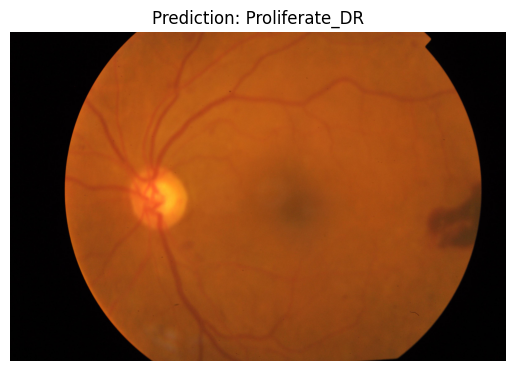

In [46]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the custom ImagePreprocessor class
class ImagePreprocessor:
    def __init__(self, clip_limit_l=5.0, clip_limit_ab=1.5, tile_grid_size=(8, 8), gamma_scale=1.2):
        self.clip_limit_l = clip_limit_l
        self.clip_limit_ab = clip_limit_ab
        self.tile_grid_size = tile_grid_size
        self.gamma_scale = gamma_scale
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Ensures all images are the same size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe_l = cv2.createCLAHE(clipLimit=self.clip_limit_l, tileGridSize=self.tile_grid_size)
        clahe_ab = cv2.createCLAHE(clipLimit=self.clip_limit_ab, tileGridSize=self.tile_grid_size)
        l_clahe = clahe_l.apply(l)
        a_clahe = clahe_ab.apply(a)
        b_clahe = clahe_ab.apply(b)
        lab_clahe = cv2.merge((l_clahe, a_clahe, b_clahe))
        return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    def adaptive_gamma_correction(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray) / 255.0
        gamma = np.clip(1.0 + (self.gamma_scale - 1.0) * (0.5 - mean_intensity), 0.5, 2.0) if mean_intensity > 0 else 1.0
        lookup_table = np.array([np.clip(((i / 255.0) ** gamma) * 255, 0, 255) for i in range(256)]).astype(np.uint8)
        return cv2.LUT(image, lookup_table)

    def preprocess(self, image):
        img_gamma = self.adaptive_gamma_correction(image)
        img_clahe = self.apply_clahe(img_gamma)
        img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
        # Convert the NumPy array to a PIL Image
        img_pil = Image.fromarray(img_rgb)
        return self.transform(img_pil)


# Step 1: Load model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.load_state_dict(torch.load("swin_sra_final_model.pth", map_location=device))
swin_model.eval()
swin_model.to(device)

# Step 2: Instantiate the preprocessor
preprocessor = ImagePreprocessor(clip_limit_l=5.0, clip_limit_ab=1.5, gamma_scale=1.2)

# Step 3: Custom preprocessing on the input image
image_path = "/content/aptos2019/train_images/f1dc26c4bfa3.png"  # Replace with your image path
image = cv2.imread(image_path)

# Preprocess the image using the ImagePreprocessor
input_tensor = preprocessor.preprocess(image).unsqueeze(0).to(device)

# Step 4: Make prediction
with torch.no_grad():
    output = swin_model(input_tensor)
    probs = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = torch.max(probs).item()

# Step 5: Print result
class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]
print(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence*100:.2f}%)")

# Optional: Show image with prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class]}")
plt.axis('off')
plt.show()


**ANALYSIS **